# Node representation learning with Deep Graph Infomax


This demo demonstrates how to perform unsupervised training of several models using [the Deep Graph Infomax algorithm](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.DeepGraphInfomax) (https://arxiv.org/pdf/1809.10341.pdf) on the CORA dataset:

- [GCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN) (both as a full-batch method, and with [the Cluster-GCN training procedure](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.ClusterNodeGenerator))
- [GAT](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GAT) (only as a full-batch method, but the Cluster-GCN training procedure is also supported)
- [APPNP](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.APPNP) (as with GAT, only as a full-batch method, but the Cluster-GCN training procedure is also supported)
- [RGCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.RGCN)
- [GraphSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GraphSAGE)
- [HinSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.HinSAGE)

As with all StellarGraph workflows: first we load the dataset, next we create our data generators, and then we train our model. We then take the embeddings created through unsupervised training and predict the node classes using logistic regression.

> See [the GCN + Deep Graph Infomax fine-tuning demo](../node-classification/gcn-deep-graph-infomax-fine-tuning-node-classification.ipynb) for semi-supervised training using Deep Graph Infomax, by fine-tuning the base model for node classification using labelled data.

In [1]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

import networkx as nx
import numpy as np

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


## Data Generators

Now we create the data generators using `CorruptedGenerator` ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.CorruptedGenerator)). `CorruptedGenerator` returns shuffled node features along with the regular node features and we train our model to discriminate between the two. 

Note that:

- We typically pass all nodes to `corrupted_generator.flow` because this is an unsupervised task
- We don't pass `targets` to `corrupted_generator.flow` because these are binary labels (true nodes, false nodes) that are created by `CorruptedGenerator`

In [4]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [13]:
fullbatch_generator.flow(G.nodes())

## GCN Model Creation and Training

We create and train our `DeepGraphInfomax` model ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.DeepGraphInfomax)). Note that the loss used here must always be `tf.nn.sigmoid_cross_entropy_with_logits`.

In [46]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [47]:
epochs = 500

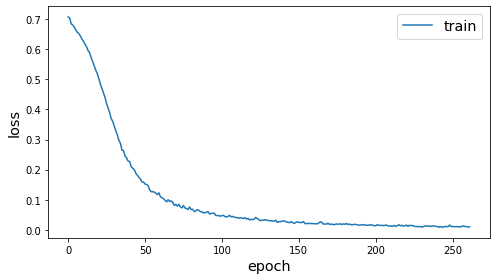

In [48]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

## Extracting Embeddings and Logistic Regression

Since we've already trained the weights of our base model - GCN in this example - we can simply use `base_model.in_out_tensors` to obtain the trained node embedding model. Then we use logistic regression on the node embeddings to predict which class the node belongs to.

Note that the results here differ from the paper due to different train/test/val splits.

In [49]:
x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

In [50]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

test_gen = fullbatch_generator.flow(test_subjects.index)
train_gen = fullbatch_generator.flow(train_subjects.index)

test_embeddings = emb_model.predict(test_gen)
train_embeddings = emb_model.predict(train_gen)

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

y_pred = lr.predict(test_embeddings)
gcn_acc = (y_pred == test_subjects).mean()
print(f"Test classification accuracy: {gcn_acc}")

Test classification accuracy: 0.8043478260869565


This accuracy is close to that for [training a supervised GCN model end-to-end](../node-classification/gcn-node-classification.ipynb), suggesting that Deep Graph Infomax is an effective method for unsupervised training.

## Visualisation with TSNE

Here we visualize the node embeddings with TSNE. As you can see below, the Deep Graph Infomax model produces well separated embeddings using unsupervised training.

In [51]:
all_embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes()))

y = node_subjects.astype("category")
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())
emb_transformed["label"] = y

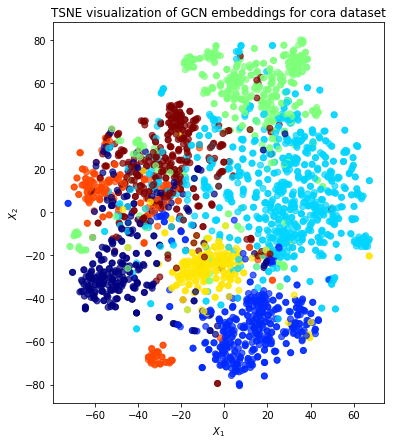

In [52]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE visualization of GCN embeddings for cora dataset")
plt.show()

## Comparing Different Models

Now we run Deep Graph Infomax training for other models. Note that switching between StellarGraph models only requires a few code changes.

In [13]:
def run_deep_graph_infomax(
    base_model, generator, epochs, reorder=lambda sequence, subjects: subjects
):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes())
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    test_gen = generator.flow(test_subjects.index)
    train_gen = generator.flow(train_subjects.index)

    test_embeddings = emb_model.predict(test_gen)
    train_embeddings = emb_model.predict(train_gen)

    # some generators yield predictions in a different order to the .flow argument,
    # so we need to get everything lined up correctly
    ordered_test_subjects = reorder(test_gen, test_subjects)
    ordered_train_subjects = reorder(train_gen, train_subjects)

    lr = LogisticRegression(multi_class="auto", solver="lbfgs")
    lr.fit(train_embeddings, ordered_train_subjects)

    y_pred = lr.predict(test_embeddings)
    acc = (y_pred == ordered_test_subjects).mean()

    return acc

### Cluster-GCN

[Cluster-GCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.ClusterNodeGenerator) is a scalable training procedure for that works for several "full batch" models in StellarGraph, including GCN, GAT and APPNP. This example just trains on GCN. The training mechanism breaks the graph into a number of small subgraph "clusters" and trains a single GCN model on these, successively. It is equivalent to full-batch GCN with a single cluster (`clusters=1`), but with `clusters > 1` random clusters (as used here), its performance will be less than GCN. With better clusters, Cluster-GCN performance should be much improved.

(Note: `ClusterNodeGenerator` can be [used with Neo4j](https://stellargraph.readthedocs.io/en/stable/demos/connector/neo4j/cluster-gcn-on-cora-neo4j-example.html) for scalable training on large graphs, including unsupervised via Deep Graph Infomax.)

In [14]:
cluster_generator = ClusterNodeGenerator(G, clusters=12, q=4)
cluster_gcn_model = GCN(
    layer_sizes=[128], activations=["relu"], generator=cluster_generator
)


def cluster_reorder(sequence, subjects):
    # shuffle the subjects into the same order as the sequence yield
    return subjects[sequence.node_order]


cluster_gcn_acc = run_deep_graph_infomax(
    cluster_gcn_model, cluster_generator, epochs=epochs, reorder=cluster_reorder
)
print(f"Test classification accuracy: {cluster_gcn_acc}")

Number of clusters 12
0 cluster has size 225
1 cluster has size 225
2 cluster has size 225
3 cluster has size 225
4 cluster has size 225
5 cluster has size 225
6 cluster has size 225
7 cluster has size 225
8 cluster has size 225
9 cluster has size 225
10 cluster has size 225
11 cluster has size 233
Test classification accuracy: 0.6308449548810501


### GAT

[GAT](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GAT) is a "full batch" model similar to GCN. It can also be trained using both `FullBatchNodeGenerator` and `ClusterNodeGenerator`, including for Deep Graph Infomax.

In [15]:
gat_model = GAT(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator, attn_heads=8,
)
gat_acc = run_deep_graph_infomax(gat_model, fullbatch_generator, epochs=epochs)

gat_acc
print(f"Test classification accuracy: {gat_acc}")

Test classification accuracy: 0.4716981132075472


### APPNP

[APPNP](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.APPNP) is a "full batch" model similar to GCN. It can also be trained using both `FullBatchNodeGenerator` and `ClusterNodeGenerator`, including for Deep Graph Infomax.

In [16]:
appnp_model = APPNP(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator
)
appnp_acc = run_deep_graph_infomax(appnp_model, fullbatch_generator, epochs=epochs)

print(f"Test classification accuracy: {appnp_acc}")

Test classification accuracy: 0.440935192780968


### GraphSAGE

[GraphSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GraphSAGE) is a sampling model, different to the models above.

In [17]:
graphsage_generator = GraphSAGENodeGenerator(G, batch_size=1000, num_samples=[5])

graphsage_model = GraphSAGE(
    layer_sizes=[128], activations=["relu"], generator=graphsage_generator
)
graphsage_acc = run_deep_graph_infomax(
    graphsage_model, graphsage_generator, epochs=epochs
)

print(f"Test classification accuracy: {graphsage_acc}")

Test classification accuracy: 0.7210828547990156


### Heterogeneous models

Cora is a homogeneous graph, with only one type of node (`paper`) and one type of edge (`type`). Models designed for heterogeneous graphs (with more than one of either) can also be applied to homogeneous graphs, but it is not using their additional flexibility.

#### HinSAGE

[HinSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.HinSAGE) is a generalisation of GraphSAGE to heterogeneous graphs that can be trained with Deep Graph Infomax. For homogeneous graphs, it is equivalent to GraphSAGE and it indeed gives similar results.

In [18]:
hinsage_generator = HinSAGENodeGenerator(
    G, batch_size=1000, num_samples=[5], head_node_type="paper"
)

hinsage_model = HinSAGE(
    layer_sizes=[128], activations=["relu"], generator=hinsage_generator
)
hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

print(f"Test classification accuracy: {hinsage_acc}")

Test classification accuracy: 0.7042657916324856


#### RGCN

[RGCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.RGCN) is a generalisation of GCN to heterogeneous graphs (with multiple edge types) that can be trained with Deep Graph Infomax. For homogeneous graphs, it is similar to GCN. It normalises the graph's adjacency matrix in a different manner and so won't exactly match it.

In [19]:
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

rgcn_generator = RelationalFullBatchNodeGenerator(G)

rgcn_model = RGCN(layer_sizes=[128], activations=["relu"], generator=rgcn_generator)

rgcn_acc = run_deep_graph_infomax(rgcn_model, rgcn_generator, epochs=epochs)
print(f"Test classification accuracy: {rgcn_acc}")

Test classification accuracy: 0.7366694011484823


### Overall results

The cell below shows the accuracy of each model.

In [20]:
pd.DataFrame(
    [gat_acc, gcn_acc, cluster_gcn_acc, appnp_acc, graphsage_acc, hinsage_acc, rgcn_acc],
    index=["GAT", "GCN", "Cluster-GCN", "APPNP", "GraphSAGE", "HinSAGE", "RGCN"],
    columns=["Accuracy"],
)

,Accuracy
GAT,0.471698
GCN,0.800246
Cluster-GCN,0.630845
APPNP,0.440935
GraphSAGE,0.721083
HinSAGE,0.704266
RGCN,0.736669


## Conclusion

This notebook demonstrated how to use [the Deep Graph Infomax algorithm](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.DeepGraphInfomax) to train other algorithms to yield useful embedding vectors for nodes, without supervision. To validate the quality of these vectors, it used logistic regression to perform a supervised node classification task.

See [the GCN + Deep Graph Infomax fine-tuning demo](../node-classification/gcn-deep-graph-infomax-fine-tuning-node-classification.ipynb) for semi-supervised training using Deep Graph Infomax, by fine-tuning the base model for node classification using labelled data.

In [2]:
filepath = "../data/output/all-edgelist.csv"

In [3]:
df = pd.read_csv(filepath, sep=",", dtype="str")

In [4]:
nx_g = nx.from_pandas_edgelist(df.loc[0:5000000], "user_id", "retweeted_user_id", create_using=nx.Graph)

In [5]:
nx_g.remove_edges_from(nx.selfloop_edges(nx_g))
nx_g = nx_g.subgraph(max(nx.connected_components(nx_g), key=len))

In [6]:
feat = pd.DataFrame.from_dict(dict(nx_g.degree()), orient="index", columns=["degree"])
feat = np.log(1 + feat.degree)

In [7]:
G = StellarGraph.from_networkx(nx_g, node_features=feat)

In [8]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 975807, Edges: 2593299

 Node types:
  default: [975807]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [2593299]
        Weights: all 1 (default)
        Features: none


In [14]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=True)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [15]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [16]:
epochs = 400

In [17]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])

Epoch 1/400
1/1 [==============================] - 0s 634us/step - loss: 0.7207
Epoch 2/400
1/1 [==============================] - 0s 799us/step - loss: 0.6932
Epoch 3/400
1/1 [==============================] - 0s 910us/step - loss: 0.6973
Epoch 4/400
1/1 [==============================] - 0s 830us/step - loss: 0.7043
Epoch 5/400
1/1 [==============================] - 0s 898us/step - loss: 0.7032
Epoch 6/400
1/1 [==============================] - 0s 877us/step - loss: 0.6978
Epoch 7/400
1/1 [==============================] - 0s 826us/step - loss: 0.6928
Epoch 8/400
1/1 [==============================] - 0s 759us/step - loss: 0.6913
Epoch 9/400
1/1 [==============================] - 0s 991us/step - loss: 0.6935
Epoch 10/400
1/1 [==============================] - 0s 809us/step - loss: 0.6962
Epoch 11/400
1/1 [==============================] - 0s 896us/step - loss: 0.6954
Epoch 12/400
1/1 [==============================] - 0s 688us/step - loss: 0.6926
Epoch 13/400
1/1 [===================

1/1 [==============================] - 0s 621us/step - loss: 0.6052
Epoch 203/400
1/1 [==============================] - 0s 933us/step - loss: 0.6047
Epoch 204/400
1/1 [==============================] - 0s 833us/step - loss: 0.6039
Epoch 205/400
1/1 [==============================] - 0s 876us/step - loss: 0.6033
Epoch 206/400
1/1 [==============================] - 0s 1ms/step - loss: 0.6026
Epoch 207/400
1/1 [==============================] - 0s 670us/step - loss: 0.6026
Epoch 208/400
1/1 [==============================] - 0s 847us/step - loss: 0.6022
Epoch 209/400
1/1 [==============================] - 0s 597us/step - loss: 0.6016
Epoch 210/400
1/1 [==============================] - 0s 759us/step - loss: 0.6006
Epoch 211/400
1/1 [==============================] - 0s 848us/step - loss: 0.6005
Epoch 212/400
1/1 [==============================] - 0s 698us/step - loss: 0.6006
Epoch 213/400
1/1 [==============================] - 0s 2ms/step - loss: 0.5989
Epoch 214/400
1/1 [===============

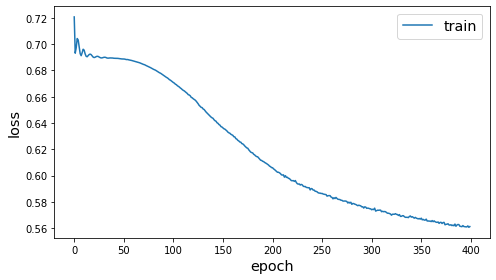

In [18]:
plot_history(history)

In [19]:
x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

In [20]:
graph_embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes()))

In [21]:
graph_embeddings.shape

(975807, 128)

### Deep info max paper:

"Given the large scale of the dataset, it will not fit into GPU memory entirely. Therefore, we use
the subsampling approach of Hamilton et al. (2017a), where a minibatch of nodes is first selected,
and then a subgraph centered around each of them is obtained by sampling node neighborhoods
with replacement. Specifically, we sample 10, 10 and 25 neighbors at the first, second and third
level, respectively—thus, each subsampled patch has 1 + 10 + 100 + 2500 = 2611 nodes. Only the
computations necessary for deriving the central node i’s patch representation, ~h i , are performed.
These representations are then used to derive the summary vector, ~s , for the minibatch (Figure 2).
We used minibatches of 256 nodes throughout training"

Talvez usar o generator de graphsage?  
GraphSAGENodeGenerator(G, batch_size, num_samples, seed=None, name=None, weighted=False)

graphsagenerator nao é compativel com GCN pelo visto